After exploring the quality of the model before, this dataframe makes the model directly

In [1]:
training_state_ids = [
    5842349984841728, # Initial 50 or so column cells
    6248348847702016, # Two additional L5 cells,
    4757235234242560, # Several cells with no detected apical that should have them
    5173788224258048, # cells that don't look good after change to l2 cache service
]

In [2]:
import json
import os
from meshparty import meshwork, trimesh_vtk
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import tqdm
import pcg_skel
import joblib

from loguru import logger
logger.add('apical_labels.log')

import sys
sys.path.append('src/')
from apical_model_utils import generate_nrn_df, process_apical_features, BranchClassifierFactory


training_skeleton_dir = './training_skeletons'
model_dir = 'models'

datastack = 'minnie65_phase3_v1'
voxel_resolution = np.array([4,4,40])

client = CAVEclient(datastack)

In [3]:
for state_id in training_state_ids:
    print(f'Neuroglancer link: {client.state.build_neuroglancer_url(state_id, "https://neuromancer-seung-import.appspot.com/")}')

Neuroglancer link: https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/5842349984841728
Neuroglancer link: https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/6248348847702016
Neuroglancer link: https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/4757235234242560
Neuroglancer link: https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/5173788224258048


In [4]:
nrn_df_fn = f'{training_skeleton_dir}/point_df_v{client.materialize.version}_{"_".join([str(x) for x in np.sort(training_state_ids)])}.feather'

if os.path.exists(nrn_df_fn):
    nrn_df = pd.read_feather(nrn_df_fn)
else:
    nrn_df = generate_nrn_df(training_state_ids, client, voxel_resolution = voxel_resolution, n_threads=1)
    nrn_df.reset_index(drop=True).to_feather(nrn_df_fn)

In [5]:
nrn_df

root_id                                                pt  \
0   864691135585980356   [192114.53125, 100998.1953125, 22504.572265625]   
1   864691135585980356   [189118.828125, 102251.015625, 22307.287109375]   
2   864691135593696811     [169576.1875, 104549.8203125, 22376.52734375]   
3   864691135593696811  [171243.046875, 103426.1640625, 22555.470703125]   
4   864691135569046918   [180950.546875, 105726.046875, 22072.638671875]   
..                 ...                                               ...   
95  864691135396687393    [186857.171875, 96051.640625, 22559.865234375]   
96  864691136134397323    [178932.734375, 94735.265625, 22230.931640625]   
97  864691135639219515        [182399.5625, 121323.0625, 22383.77734375]   
98  864691135785652932           [185253.9375, 175188.25, 21582.3046875]   
99  864691134988755578    [210862.78125, 246796.828125, 24229.380859375]   

                      pt_vx          state_id                l2id  \
0   [192114, 100998, 22504]  5842349984841728  163260847550891376   
1   [189118, 102251, 22307]  5842349984841728  162838841244255036   
2   [169576, 104549, 22376]  5842349984841728  160165103843410888   
3   [171243, 103426, 22555]  5842349984841728  160376072704098422   
4   [180950, 105726, 22072]  5842349984841728  161713422373748848   
..                      ...               ...                 ...   
95   [186857, 96051, 22559]  5173788224258048  162486172956753928   
96   [178932, 94735, 22230]  5173788224258048  161430435568550574   
97  [182399, 121323, 22383]  5173788224258048  161926590190584561   
98  [185253, 175188, 21582]  5173788224258048  162285649389420704   
99  [210862, 246796, 24229]  5173788224258048  165813707660591407   

          root_id_curr  
0   864691136194607436  
1   864691136194607436  
2   864691136388620151  
3   864691136388620151  
4   864691135501952578  
..                 ...  
95  864691135396687393  
96  864691136134397323  
97  864691135639219515  
98  864691135785652932  
99  864691134988755578  

[100 rows x 6 columns]

Download all relevent skeletons and assign manual apical labels

In [6]:
cache_file = 'service'

In [7]:
oids = np.unique(nrn_df['root_id_curr'])

for oid in tqdm.tqdm(oids):
    spec_df = nrn_df.query('root_id_curr == @oid')
    skel_file = f'{training_skeleton_dir}/{oid}_with_apical.h5'
    skel_file_training = f'{training_skeleton_dir}/{oid}_with_apical.h5'
    
    if os.path.exists(skel_file_training):
        continue

    if os.path.exists(skel_file):
        logger.info(f'Loading {oid} from file')
        nrn = meshwork.load_meshwork(skel_file)
    else:
        logger.info(f'Loading {oid} from pcg_skel')
        soma_df = client.materialize.query_table('nucleus_detection_v0',
                                                 filter_equal_dict={
                                                     'pt_root_id': oid,
                                                 })
        soma_pt = soma_df.iloc[0]['pt_position'].squeeze()
        
        nrn = pcg_skel.coord_space_meshwork(
            oid,
            client=client,
            root_point=soma_pt,
            root_point_resolution=[4,4,40],
            collapse_soma=True,
            synapse_table=client.info.get_datastack_info().get('synapse_table'),
            synapses='all',
            require_complete=True,
        )
        
        pcg_skel.features.add_volumetric_properties(nrn, client)
        pcg_skel.features.add_segment_properties(nrn)

        # nrn = pcg_skel.pcg_meshwork(oid,
        #                             client=client,
        #                             collapse_soma=True,
        #                             refine='all',
        #                             synapse_table=project_info.synapse_table,
        #                             synapses='all',
        #                             root_point=soma_pt,
        #                             root_point_resolution=[4,4,40],
        #                             cache=cache_file,
        #                             save_to_cache=True,
        #                             segmentation_fallback=False,
        #                             n_parallel=8)

    if "is_axon" not in nrn.anno.table_names:
        logger.info(f'Computing axon for {oid}')
        if len(nrn.anno.pre_syn) > 0 and len(nrn.anno.post_syn) > 0:
            is_axon, split_quality = meshwork.algorithms.split_axon_by_synapses(
                nrn, nrn.anno.pre_syn.mesh_index, nrn.anno.post_syn.mesh_index
            )
        else:
            split_quality = -1
            is_axon = []
        nrn.anno.add_annotations("is_axon", is_axon, mask=True)

    logger.info(f'Processing apical points for {oid}')
    ap_pts = np.vstack(nrn_df.query(f'root_id_curr == @oid',
                   engine='python')['pt_vx'].values)

    ap_l2ids = nrn_df.query('root_id_curr == @oid', engine='python')['l2id'].values
    ap_minds = nrn.anno.lvl2_ids.df.query('lvl2_id in @ap_l2ids')['mesh_ind'].values

    all_apical = []
    for ap_mind in ap_minds:
        ptr = nrn.path_between(ap_mind, nrn.root, return_as_skel=True)
        ptr_nr = ptr[ptr!=nrn.skeleton.root]
        if len(ptr_nr) > 0:
            apical_pts = nrn.downstream_of(ptr_nr[[0]])
            all_apical.append(apical_pts[0].to_skel_index)
    all_apical = np.unique(np.concatenate(all_apical))
    
    try:
        nrn.anno.remove_annotations('is_apical')
    except:
        pass

    nrn.anno.add_annotations('is_apical', nrn.SkeletonIndex(all_apical).to_mesh_index, mask=True)
    nrn.save_meshwork(skel_file_training, overwrite=True)

100%|███████████████████████████████████████| 88/88 [00:00<00:00, 1194.32it/s]


Apply apical labels as annotations to all the files

---

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
oid = oids[1]

In [76]:
skel_file = f'{training_skeleton_dir}/{oid}_with_apical.h5'
nrn = meshwork.load_meshwork(skel_file)

In [ ]:
ska = trimesh_vtk.skeleton_actor(nrn.skeleton, color=(0,0,0), line_width=1)
pca = trimesh_vtk.point_cloud_actor(nrn.skeleton.vertices[apical_pts], color=(1,0,0), opacity=0.3, size=2000)
trimesh_vtk.render_actors([ska, pca])

In [ ]:
example_test_df = pt_feature_df.query('root_id == @oid').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='pt_x', y='pt_y', hue='is_apical', data=example_test_df, palette='RdBu', ax=ax, legend=False)
ax.invert_yaxis()
ax.set_aspect('equal')

In [18]:
for oid in tqdm.tqdm(np.unique(nrn_df['root_id_curr'])):
    skel_file = f'{training_skeleton_dir}/{oid}_with_apical.h5'
    nrn = meshwork.load_meshwork(skel_file)
    
    ap_pts = np.vstack(nrn_df.query(f'root_id_curr == @oid',
                       engine='python')['pt_vx'].values)

    ap_l2ids = nrn_df.query('root_id_curr == @oid', engine='python')['l2id'].values

    ap_minds = nrn.anno.lvl2_ids.df.query('lvl2_id in @ap_l2ids')['mesh_ind'].values

    all_apical = []
    for ap_mind in ap_minds:
        ptr = nrn.path_between(ap_mind, nrn.root, return_as_skel=True)
        ptr_nr = ptr[ptr!=nrn.skeleton.root]
        if len(ptr_nr) > 0:
            closest_idx = np.argmin(nrn.skeleton.distance_to_root[ptr_nr])
            apical_pts = nrn.skeleton.downstream_nodes(ptr_nr[closest_idx])
            all_apical.append(apical_pts)
    all_apical = np.unique(np.concatenate(all_apical))
    nrn.anno.remove_annotations('is_apical')
    nrn.anno.add_annotations('is_apical', nrn.SkeletonIndex(all_apical).to_mesh_index, mask=True)
    nrn.save_meshwork(skel_file, overwrite=True)

  1%|▍                                         | 1/88 [00:00<00:15,  5.50it/s]

	Deleting existing data in ./training_skeletons/864691134988755578_with_apical.h5...


  3%|█▍                                        | 3/88 [00:00<00:15,  5.46it/s]

	Deleting existing data in ./training_skeletons/864691134988904570_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135181977858_with_apical.h5...


  5%|█▉                                        | 4/88 [00:00<00:20,  4.20it/s]

	Deleting existing data in ./training_skeletons/864691135274322149_with_apical.h5...


  6%|██▍                                       | 5/88 [00:01<00:18,  4.39it/s]

	Deleting existing data in ./training_skeletons/864691135341429189_with_apical.h5...


  7%|██▊                                       | 6/88 [00:01<00:19,  4.23it/s]

	Deleting existing data in ./training_skeletons/864691135341441477_with_apical.h5...


  8%|███▎                                      | 7/88 [00:01<00:19,  4.16it/s]

	Deleting existing data in ./training_skeletons/864691135341598385_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135355207375_with_apical.h5...


 11%|████▋                                    | 10/88 [00:01<00:12,  6.06it/s]

	Deleting existing data in ./training_skeletons/864691135358807384_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135367351801_with_apical.h5...


 14%|█████▌                                   | 12/88 [00:02<00:11,  6.89it/s]

	Deleting existing data in ./training_skeletons/864691135382723290_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135385700437_with_apical.h5...


 15%|██████                                   | 13/88 [00:02<00:12,  6.04it/s]

	Deleting existing data in ./training_skeletons/864691135394166773_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135394257141_with_apical.h5...


 18%|███████▍                                 | 16/88 [00:02<00:09,  7.76it/s]

	Deleting existing data in ./training_skeletons/864691135396555809_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135396687393_with_apical.h5...


 19%|███████▉                                 | 17/88 [00:02<00:10,  6.84it/s]

	Deleting existing data in ./training_skeletons/864691135407449033_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135445835922_with_apical.h5...


 22%|████████▊                                | 19/88 [00:03<00:13,  4.98it/s]

	Deleting existing data in ./training_skeletons/864691135445975698_with_apical.h5...


 23%|█████████▎                               | 20/88 [00:03<00:14,  4.67it/s]

	Deleting existing data in ./training_skeletons/864691135463052350_with_apical.h5...


 24%|█████████▊                               | 21/88 [00:03<00:13,  4.90it/s]

	Deleting existing data in ./training_skeletons/864691135463952709_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135501692226_with_apical.h5...


 26%|██████████▋                              | 23/88 [00:04<00:11,  5.54it/s]

	Deleting existing data in ./training_skeletons/864691135501952578_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135538569074_with_apical.h5...


 28%|███████████▋                             | 25/88 [00:04<00:12,  5.13it/s]

	Deleting existing data in ./training_skeletons/864691135560494305_with_apical.h5...


 30%|████████████                             | 26/88 [00:04<00:11,  5.42it/s]

	Deleting existing data in ./training_skeletons/864691135564761879_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135571024365_with_apical.h5...


 32%|█████████████                            | 28/88 [00:05<00:09,  6.47it/s]

	Deleting existing data in ./training_skeletons/864691135571456037_with_apical.h5...


 33%|█████████████▌                           | 29/88 [00:05<00:10,  5.41it/s]

	Deleting existing data in ./training_skeletons/864691135575645982_with_apical.h5...


 34%|█████████████▉                           | 30/88 [00:05<00:10,  5.32it/s]

	Deleting existing data in ./training_skeletons/864691135576996357_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135577244165_with_apical.h5...


 36%|██████████████▉                          | 32/88 [00:05<00:09,  5.60it/s]

	Deleting existing data in ./training_skeletons/864691135581747053_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135582010733_with_apical.h5...


 39%|███████████████▊                         | 34/88 [00:06<00:10,  4.97it/s]

	Deleting existing data in ./training_skeletons/864691135590140683_with_apical.h5...


 41%|████████████████▊                        | 36/88 [00:06<00:10,  5.19it/s]

	Deleting existing data in ./training_skeletons/864691135600255940_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135614152907_with_apical.h5...


 43%|█████████████████▋                       | 38/88 [00:06<00:07,  6.36it/s]

	Deleting existing data in ./training_skeletons/864691135639219515_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135687112672_with_apical.h5...


 44%|██████████████████▏                      | 39/88 [00:07<00:07,  6.85it/s]

	Deleting existing data in ./training_skeletons/864691135696154522_with_apical.h5...


 45%|██████████████████▋                      | 40/88 [00:07<00:10,  4.61it/s]

	Deleting existing data in ./training_skeletons/864691135730543289_with_apical.h5...


 48%|███████████████████▌                     | 42/88 [00:07<00:07,  6.02it/s]

	Deleting existing data in ./training_skeletons/864691135748884521_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135776101293_with_apical.h5...


 49%|████████████████████                     | 43/88 [00:07<00:07,  5.76it/s]

	Deleting existing data in ./training_skeletons/864691135776972128_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135777372349_with_apical.h5...


 51%|████████████████████▉                    | 45/88 [00:08<00:06,  6.27it/s]

	Deleting existing data in ./training_skeletons/864691135785652932_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135785765572_with_apical.h5...


 53%|█████████████████████▉                   | 47/88 [00:08<00:07,  5.15it/s]

	Deleting existing data in ./training_skeletons/864691135800098658_with_apical.h5...


 55%|██████████████████████▎                  | 48/88 [00:08<00:08,  4.97it/s]

	Deleting existing data in ./training_skeletons/864691135800099938_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135815831119_with_apical.h5...


 57%|███████████████████████▎                 | 50/88 [00:09<00:06,  5.86it/s]

	Deleting existing data in ./training_skeletons/864691135841236451_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135884296304_with_apical.h5...


 59%|████████████████████████▏                | 52/88 [00:09<00:06,  5.52it/s]

	Deleting existing data in ./training_skeletons/864691135888897161_with_apical.h5...


 60%|████████████████████████▋                | 53/88 [00:09<00:07,  4.68it/s]

	Deleting existing data in ./training_skeletons/864691135925745422_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135939942401_with_apical.h5...


 64%|██████████████████████████               | 56/88 [00:10<00:05,  6.24it/s]

	Deleting existing data in ./training_skeletons/864691135941293428_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135941436020_with_apical.h5...


 66%|███████████████████████████              | 58/88 [00:10<00:04,  6.96it/s]

	Deleting existing data in ./training_skeletons/864691135952133155_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691135974646895_with_apical.h5...


 67%|███████████████████████████▍             | 59/88 [00:10<00:04,  6.48it/s]

	Deleting existing data in ./training_skeletons/864691135975686467_with_apical.h5...


 68%|███████████████████████████▉             | 60/88 [00:10<00:05,  5.23it/s]

	Deleting existing data in ./training_skeletons/864691135976107843_with_apical.h5...


 69%|████████████████████████████▍            | 61/88 [00:11<00:05,  5.40it/s]

	Deleting existing data in ./training_skeletons/864691136008663212_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136020322296_with_apical.h5...


 72%|█████████████████████████████▎           | 63/88 [00:11<00:04,  5.40it/s]

	Deleting existing data in ./training_skeletons/864691136020517624_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136031895483_with_apical.h5...


 73%|█████████████████████████████▊           | 64/88 [00:11<00:04,  5.79it/s]

	Deleting existing data in ./training_skeletons/864691136032002235_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136039804158_with_apical.h5...


 76%|███████████████████████████████▏         | 67/88 [00:12<00:03,  5.30it/s]

	Deleting existing data in ./training_skeletons/864691136056724952_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136118738456_with_apical.h5...


 80%|████████████████████████████████▌        | 70/88 [00:12<00:02,  6.83it/s]

	Deleting existing data in ./training_skeletons/864691136134397323_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136143686452_with_apical.h5...


 81%|█████████████████████████████████        | 71/88 [00:12<00:02,  7.30it/s]

	Deleting existing data in ./training_skeletons/864691136143686708_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136194541288_with_apical.h5...


 83%|██████████████████████████████████       | 73/88 [00:13<00:02,  5.17it/s]

	Deleting existing data in ./training_skeletons/864691136194607436_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136237074191_with_apical.h5...


 85%|██████████████████████████████████▉      | 75/88 [00:13<00:02,  5.82it/s]

	Deleting existing data in ./training_skeletons/864691136286604995_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136296910107_with_apical.h5...


 88%|███████████████████████████████████▉     | 77/88 [00:13<00:01,  5.89it/s]

	Deleting existing data in ./training_skeletons/864691136361889506_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136388620151_with_apical.h5...


 90%|████████████████████████████████████▊    | 79/88 [00:14<00:01,  4.59it/s]

	Deleting existing data in ./training_skeletons/864691136389034256_with_apical.h5...


 91%|█████████████████████████████████████▎   | 80/88 [00:14<00:01,  5.03it/s]

	Deleting existing data in ./training_skeletons/864691136483213612_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136602130129_with_apical.h5...


 93%|██████████████████████████████████████▏  | 82/88 [00:14<00:01,  5.58it/s]

	Deleting existing data in ./training_skeletons/864691136672965767_with_apical.h5...
	Deleting existing data in ./training_skeletons/864691136672967303_with_apical.h5...


 95%|███████████████████████████████████████▏ | 84/88 [00:15<00:00,  4.77it/s]

	Deleting existing data in ./training_skeletons/864691136923138020_with_apical.h5...


 97%|███████████████████████████████████████▌ | 85/88 [00:15<00:00,  5.40it/s]

	Deleting existing data in ./training_skeletons/864691136952134623_with_apical.h5...


 98%|████████████████████████████████████████ | 86/88 [00:15<00:00,  4.65it/s]

	Deleting existing data in ./training_skeletons/864691136974021660_with_apical.h5...


 99%|████████████████████████████████████████▌| 87/88 [00:15<00:00,  4.81it/s]

	Deleting existing data in ./training_skeletons/864691137019791726_with_apical.h5...


100%|█████████████████████████████████████████| 88/88 [00:16<00:00,  5.43it/s]

	Deleting existing data in ./training_skeletons/864691137197070913_with_apical.h5...


---
#### Extract synapses from training data and generate model

In [19]:
pt_feature_dfs = []
for oid in tqdm.tqdm(oids):
    skel_file = f'{training_skeleton_dir}/{oid}_with_apical.h5'
    nrn = meshwork.load_meshwork(skel_file)
    nrn.reset_mask()
    point_features_df = process_apical_features(nrn)
    nrn.reset_mask()
    point_features_df['is_apical'] = nrn.anno.is_apical.mesh_index.to_skel_mask[point_features_df['v_skind_base']]
    pt_feature_dfs.append(point_features_df)

pt_feature_df = pd.concat(pt_feature_dfs)
del pt_feature_dfs

100%|█████████████████████████████████████████| 88/88 [01:47<00:00,  1.22s/it]


In [20]:
feature_cols = ['del_y',
                'del_r',
                'rho',
                'theta',
                'pt_y', 
                'dist_to_root',
                'dist_from_tip',
                'dist_to_root_rel',
                'tort',
                'soma_y',
                'bp_to_root',
]

In [21]:
pt_feature_df = pt_feature_df.reset_index(drop=True)

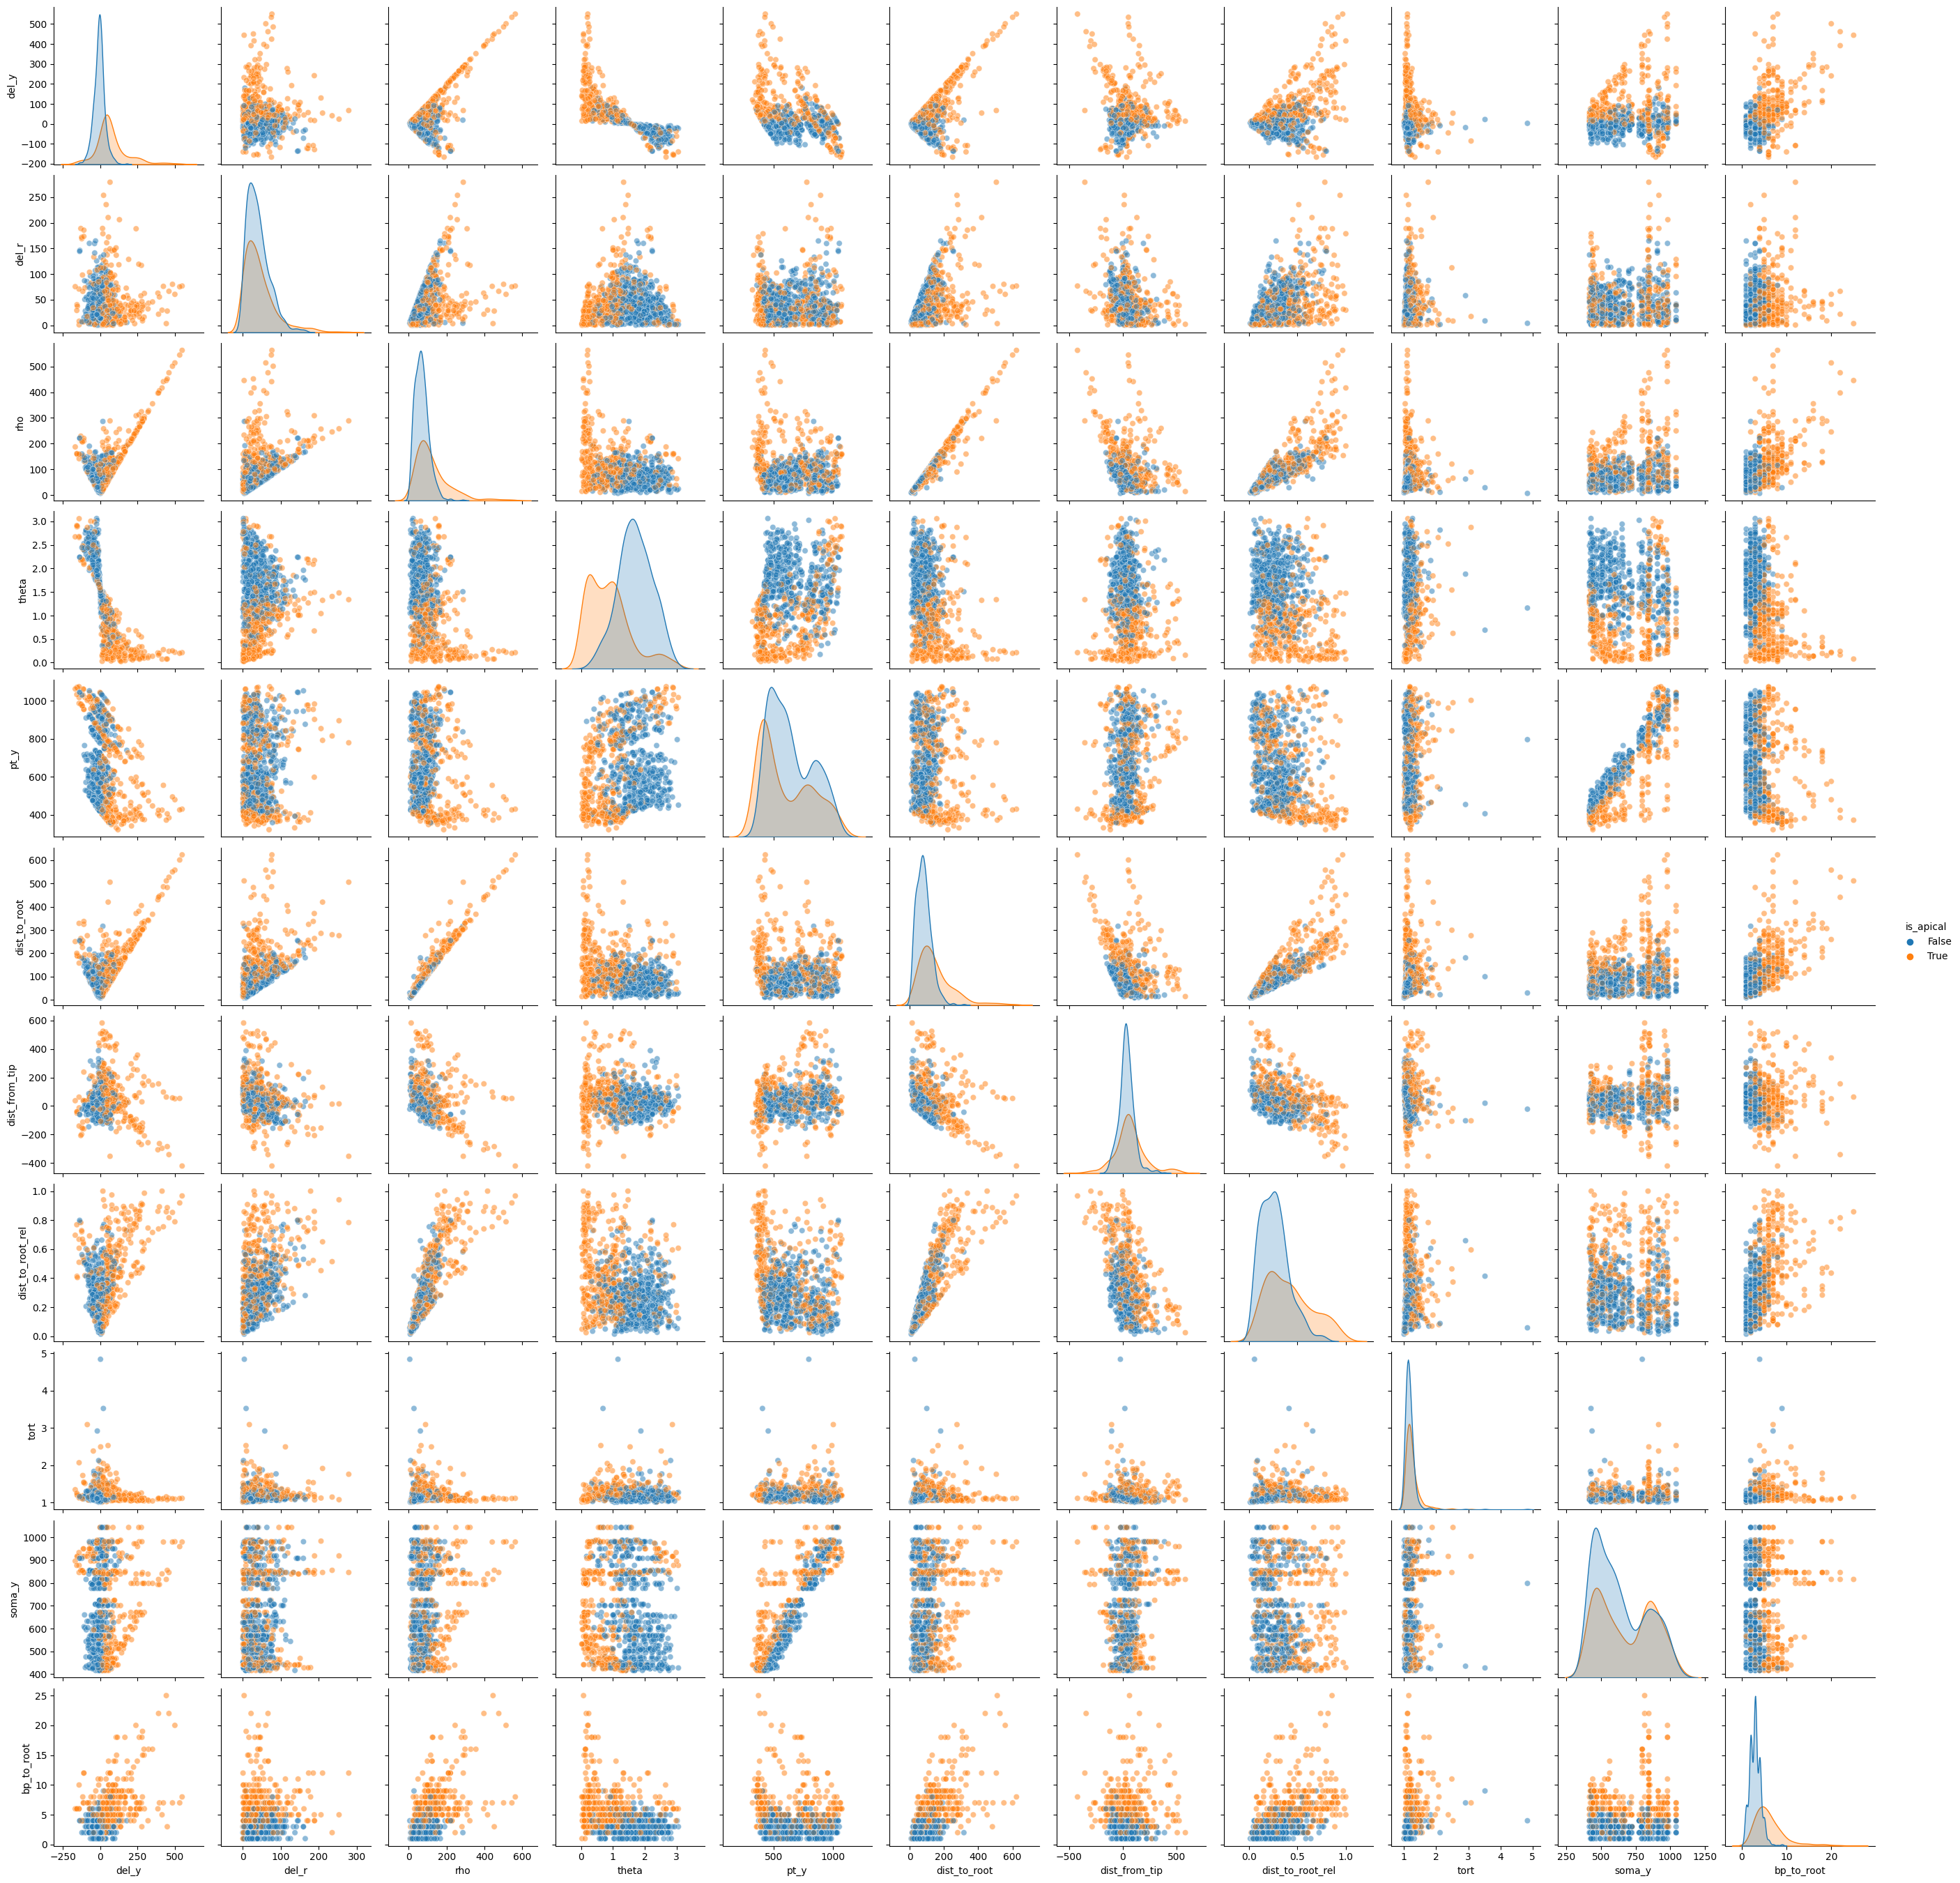

In [22]:
import seaborn as sns
sns.pairplot(pt_feature_df.sample(1000),
             vars=feature_cols,
             hue='is_apical',
             plot_kws=dict(alpha=0.5))

In [24]:
from imblearn import over_sampling
from sklearn.ensemble import RandomForestClassifier
import joblib

In [25]:
point_data = pt_feature_df[feature_cols].values
is_apical_all = pt_feature_df['is_apical']

In [26]:
smote = over_sampling.SMOTE()
X_res, y_res = smote.fit_resample(point_data, is_apical_all)
rfc = RandomForestClassifier(n_estimators=200,
                             max_features=4,
                             n_jobs=8,
                             )
rfc.fit(X_res, y_res)

RandomForestClassifier(max_features=4, n_estimators=200, n_jobs=8)

### Branch classifier

Currently somewhat ad-hoc, but principled. Treat the question like Bayesian model selection: Given the classifier results, is a branch more likely to be an apical or basal dendrite.

* Compute log-odds ratio for apical vs not-apical.
* Because points are not actually independent from one another, scale this down.
* Ignore branches that are too short to be an apical dendrite
* Neurons have between zero and a few apical dendrites, so use a softmax to declare a winner if the most "apicalish" dendrite is much more apical than others, but allow ties if several neurites are similarly "apicalish".
* Classify as apical branches that have both a positive log-odds ratio and are above a given softmax threshold.

In [71]:
branch_classifier_params = dict(min_length=50,
                                logodds_clip=200,
                                softmax_scaler=50,
                                bin_num=80,
                                logodds_thresh=0,
                                softmax_thresh=0.3)

In [28]:
classifier_fn = f'{model_dir}/point_model_current.pkl'
feature_cols_fn = f'{model_dir}/feature_cols_current.pkl'
branch_classifier_params_fn = f'{model_dir}/branch_params_current.pkl'

version_post = f'{client.materialize.version}_{"_".join([str(x) for x in np.sort(training_state_ids)])}'

classifier_specific_fn = f'{model_dir}/point_model_v{version_post}.pkl'
feature_cols_specific_fn = f'{model_dir}/feature_cols_v{version_post}.pkl'
branch_classifier_params_specific_fn = f'{model_dir}/branch_params_v{version_post}.pkl'

In [ ]:
joblib.dump(rfc, classifier_fn)
joblib.dump(feature_cols, feature_cols_fn)
joblib.dump(branch_classifier_params, branch_classifier_params_fn)

joblib.dump(rfc, classifier_specific_fn)
joblib.dump(feature_cols, feature_cols_specific_fn)
joblib.dump(branch_classifier_params, branch_classifier_params_specific_fn)

---

In [ ]:
864691136672967303

In [132]:
ex_root_id = oids[1]
example_df = pt_feature_df.query('root_id != @ex_root_id').reset_index(drop=True)
point_data = example_df[feature_cols].values
is_apical_all = example_df['is_apical']

X_res, y_res = smote.fit_resample(point_data, is_apical_all)
rfc_ex = RandomForestClassifier(n_estimators=200,
                             max_features=4,
                             n_jobs=8,
                             )

rfc_ex.fit(X_res, y_res)

RandomForestClassifier(max_features=4, n_estimators=200, n_jobs=8)

In [133]:
import matplotlib.pyplot as plt


In [145]:
oids

array([864691134988755578, 864691134988904570, 864691135181977858,
       864691135274322149, 864691135341429189, 864691135341441477,
       864691135341598385, 864691135355207375, 864691135358807384,
       864691135367351801, 864691135382723290, 864691135385700437,
       864691135394166773, 864691135394257141, 864691135396555809,
       864691135396687393, 864691135407449033, 864691135445835922,
       864691135445975698, 864691135463052350, 864691135463952709,
       864691135501692226, 864691135501952578, 864691135538569074,
       864691135560494305, 864691135564761879, 864691135571024365,
       864691135571456037, 864691135575645982, 864691135576996357,
       864691135577244165, 864691135581747053, 864691135582010733,
       864691135590140683, 864691135600255940, 864691135614152907,
       864691135639219515, 864691135687112672, 864691135696154522,
       864691135730543289, 864691135748884521, 864691135776101293,
       864691135776972128, 864691135777372349, 864691135785652

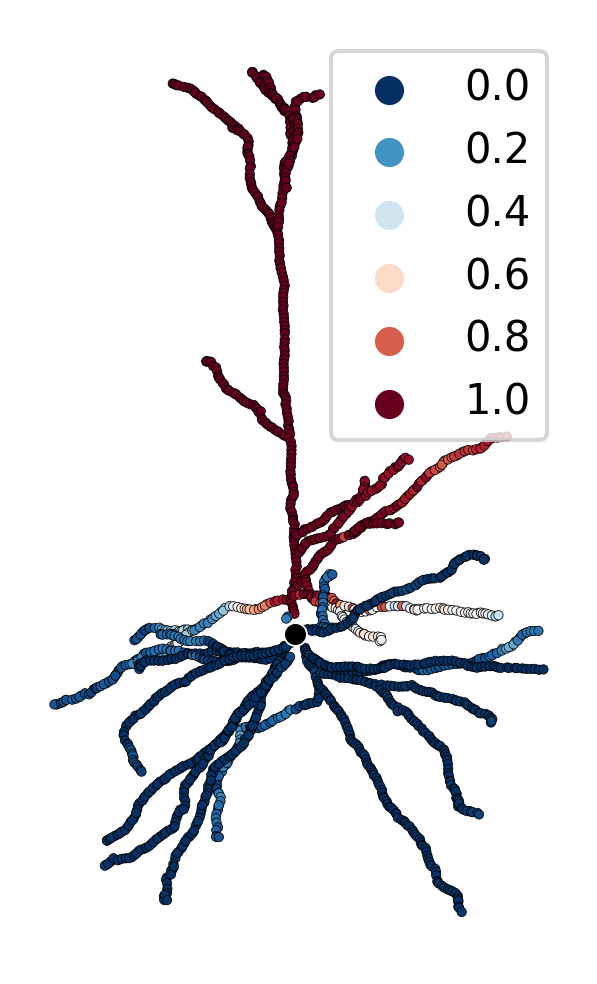

In [144]:
example_test_df = pt_feature_df.query('root_id == @ex_root_id').reset_index(drop=True)
example_test_df['prob_ap'] = rfc_ex.predict_proba(example_test_df[feature_cols].values)[:,1]

fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.scatterplot(x='pt_x', y='pt_y', hue='prob_ap', s=5, data=example_test_df, palette='RdBu_r', ax=ax, edgecolor='k', legend=True)
sns.scatterplot(x='soma_x', y='soma_y', color='k', data=example_test_df.iloc[0:1], s=30)
ax.invert_yaxis()
ax.set_aspect('equal')

sns.despine(ax=ax, left=True, bottom=True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.savefig(f"/Users/caseysm/Work/Projects/MinnieColumn/notebooks/paper_versions/apical_example_{ex_root_id}_cbar.pdf")


In [ ]:
BranchClassifier = BranchClassifierFactory(rfc_ex, feature_cols)
branch_classifier = BranchClassifier(**branch_classifier_params)

In [ ]:
df_test = pt_feature_df.query('root_id == @ex_root_id', engine='python').reset_index(drop=True)
df_test = df_test.rename(columns={'is_apical': 'is_apical_gt'})
branch_df = branch_classifier.fit_predict_data(df_test, 'base_skind')

In [ ]:
branch_df

---

### Check the model with Leave-one-out analysis of the training data

In [ ]:
loo_predictions = []
oids = np.unique(pt_feature_df['root_id'])
results = []
for oid in tqdm.tqdm(oids):
    df = pt_feature_df.query('root_id != @oid', engine='python').reset_index(drop=True)
    feat_data = df[feature_cols].values
    is_apical = df['is_apical'].values

    rfc = RandomForestClassifier(n_estimators=200,
                                 max_features=4,
                                 n_jobs=8,
                                 )
    rfc.fit(feat_data, is_apical)
    BranchClassifier = BranchClassifierFactory(rfc, feature_cols)
    branch_classifier = BranchClassifier(**branch_classifier_params)
    
    df_test = pt_feature_df.query('root_id == @oid', engine='python').reset_index(drop=True)
    df_test = df_test.rename(columns={'is_apical': 'is_apical_gt'})
    
    branch_df = branch_classifier.fit_predict_data(df_test, 'base_skind')
    branch_df['root_id'] = oid
    branch_df = branch_df.merge(df_test.groupby('base_skind').sample(1)[['base_skind', 'is_apical_gt']], on='base_skind')
    results.append(branch_df)
all_branch = pd.concat(results)

 67%|███████████████████████████▍             | 59/88 [11:01<05:25, 11.22s/it]


KeyboardInterrupt: 

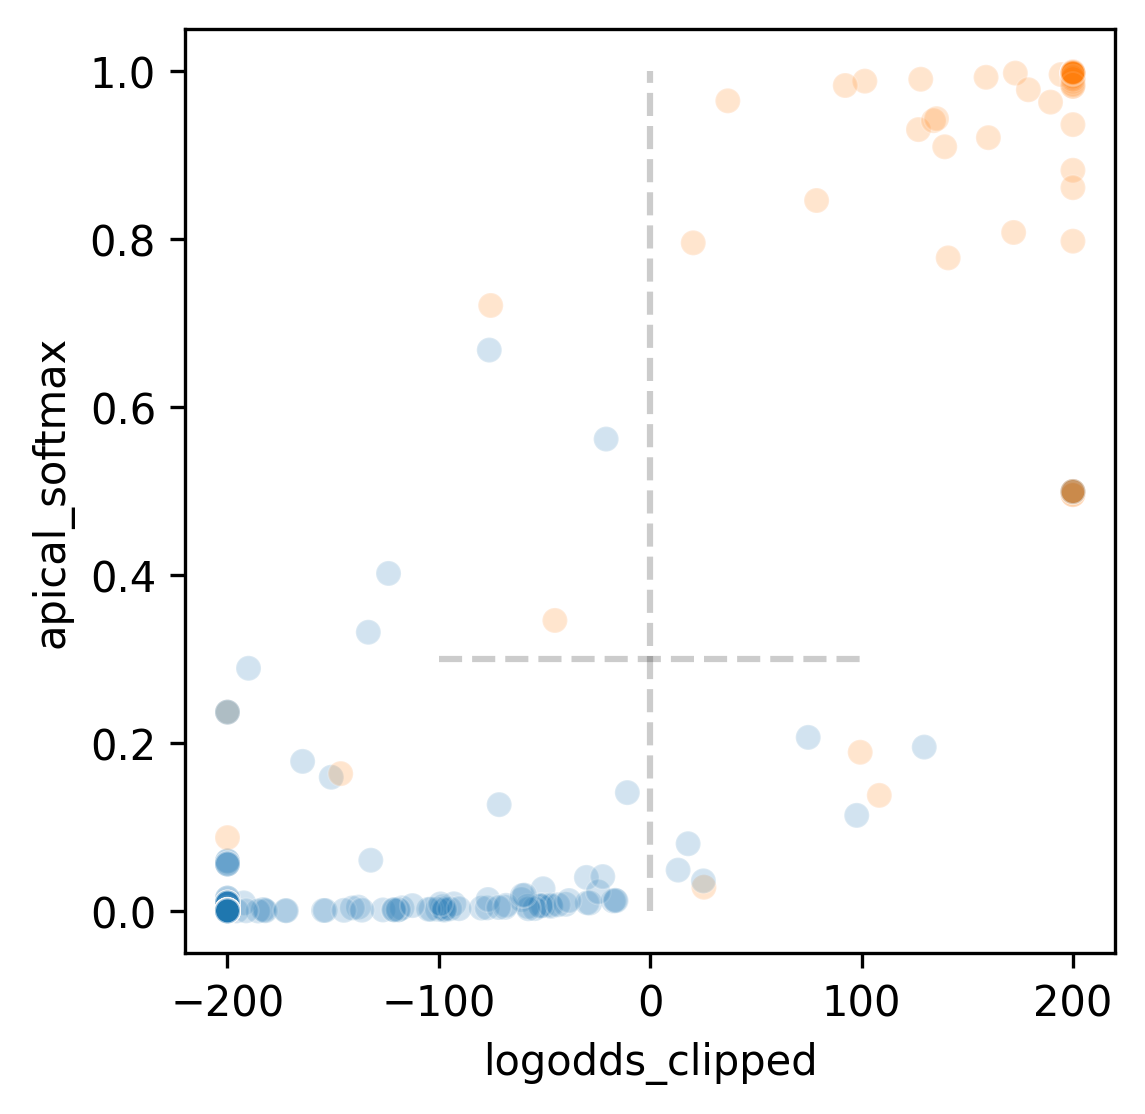

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
sns.scatterplot(y='apical_softmax', x='logodds_clipped', hue='is_apical_gt', data=all_branch.query(f'len_br > {branch_classifier_params["min_length"]}'), alpha=0.2, legend=False) 
ax.plot((-100, 100), (0.3, 0.3), 'k--', alpha=0.2)
ax.plot((0,0), (0,1), 'k--', alpha=0.2)

fig.savefig('/Users/caseysm/Work/Projects/MinnieColumn/notebooks/paper_versions/apical_space_plot.pdf')

In [37]:
all_branch.pivot_table(index='is_apical', columns='is_apical_gt', values='len_br', aggfunc=len)

is_apical_gt  False  True 
is_apical                 
False           599     11
True              2     86

In [4]:
from sklearn import metrics
import numpy as np

In [5]:
np.arange(20, 300, 30)

array([ 20,  50,  80, 110, 140, 170, 200, 230, 260, 290])

In [38]:
found_ids = np.unique(all_branch.query('is_apical == False and is_apical_gt == True')['root_id'])

In [1]:
found_ids

NameError: name 'found_ids' is not defined

In [53]:
all_branch.query('root_id == @found_ids[10]')

base_skind                                        apical_prob  \
0         2013  [0.005, 0.005, 0.005, 0.005, 0.01, 0.01, 0.005...   
1         2183  [0.275, 0.225, 0.275, 0.285, 0.35, 0.335, 0.38...   
2         2184  [0.93, 0.94, 0.94, 0.95, 0.945, 0.95, 0.955, 0...   
3         2285  [0.02, 0.015, 0.005, 0.015, 0.015, 0.02, 0.025...   
4         2401  [0.125, 0.095, 0.05, 0.04, 0.025, 0.035, 0.025...   
5         2514  [0.515, 0.45, 0.43, 0.435, 0.42, 0.395, 0.3, 0...   
6         2518  [0.05, 0.06, 0.085, 0.08, 0.075, 0.09, 0.105, ...   
7         2525  [0.02, 0.025, 0.0, 0.025, 0.095, 0.05, 0.125, ...   
8         2533  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9         2693  [0.51, 0.515, 0.515, 0.605, 0.615, 0.62, 0.655...   
10        2694  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005, 0.0, 0.0...   
11        2813  [0.09, 0.085, 0.07, 0.05, 0.015, 0.15, 0.145, ...   

    logodds_ratio  len_br  logodds_clipped  softmax_denom  softmax_num  \
0    -1591.700047     186      -200.000000       55.48131     0.018316   
1     -293.632054     151      -200.000000       55.48131     0.018316   
2      464.804543     561       200.000000       55.48131    54.598150   
3     -919.871684     109      -200.000000       55.48131     0.018316   
4    -1221.353638     106      -200.000000       55.48131     0.018316   
5      -16.542059     124       -16.542059       55.48131     0.718319   
6     -634.026867     118      -200.000000       55.48131     0.018316   
7      -68.153551      47       -68.153551       55.48131     0.255874   
8    -1733.130671     117      -200.000000       55.48131     0.018316   
9     -549.611228     558      -200.000000       55.48131     0.018316   
10   -1108.144290     104      -200.000000       55.48131     0.018316   
11   -1135.498907     139      -200.000000       55.48131     0.018316   

    apical_softmax  is_apical             root_id  is_apical_gt  
0         0.000330      False  864691136923138020         False  
1         0.000330      False  864691136923138020         False  
2         0.984082       True  864691136923138020          True  
3         0.000330      False  864691136923138020         False  
4         0.000330      False  864691136923138020         False  
5         0.012947      False  864691136923138020         False  
6         0.000330      False  864691136923138020         False  
7         0.004612      False  864691136923138020         False  
8         0.000330      False  864691136923138020         False  
9         0.000330      False  864691136923138020          True  
10        0.000330      False  864691136923138020         False  
11        0.000330      False  864691136923138020         False

In [122]:
all_branch['num_br_gt'] = all_branch.groupby(['root_id', 'is_apical_gt']).transform('count')['base_skind']
all_branch['num_br'] = all_branch.groupby(['root_id', 'is_apical']).transform('count')['base_skind']

In [147]:
all_branch.query('num_br_gt > 2')

base_skind                                        apical_prob  \
0          961  [0.075, 0.075, 0.08, 0.085, 0.085, 0.085, 0.07...   
1          962  [0.005, 0.0, 0.005, 0.0, 0.03, 0.07, 0.115, 0....   
2         1042  [0.045, 0.045, 0.03, 0.135, 0.185, 0.155, 0.18...   
3         1082  [0.025, 0.015, 0.02, 0.025, 0.03, 0.055, 0.02,...   
0          951  [0.005, 0.005, 0.0, 0.0, 0.0, 0.0, 0.005, 0.00...   
..         ...                                                ...   
4         1750  [0.82, 0.755, 0.76, 0.655, 0.285, 0.835, 0.305...   
5         1752  [0.005, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
6         1825  [0.01, 0.015, 0.005, 0.015, 0.005, 0.005, 0.00...   
7         2033  [0.0, 0.0, 0.0, 0.0, 0.0, 0.005, 0.0, 0.005, 0...   
8         2035  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

    logodds_ratio  len_br  logodds_clipped  softmax_denom  softmax_num  \
0       17.935001     371        17.935001      17.834867     1.431467   
1      -68.742241      10       -68.742241      17.834867     0.252879   
2      -92.878959      97       -92.878959      17.834867     0.156050   
3     -670.927576     368      -200.000000      17.834867     0.018316   
0    -1432.064448      95      -200.000000      54.726360     0.018316   
..            ...     ...              ...            ...          ...   
4     -320.180864     421      -200.000000      54.708044     0.018316   
5    -1099.205432      97      -200.000000      54.708044     0.018316   
6     -829.207577     154      -200.000000      54.708044     0.018316   
7     -145.291842      12      -145.291842      54.708044     0.054703   
8    -1299.484050     164      -200.000000      54.708044     0.018316   

    apical_softmax  is_apical             root_id  is_apical_gt  num_br_gt  \
0         0.080262      False  864691134988755578         False          4   
1         0.014179      False  864691134988755578         False          4   
2         0.008750      False  864691134988755578         False          4   
3         0.001027      False  864691134988755578         False          4   
0         0.000335      False  864691134988904570         False          8   
..             ...        ...                 ...           ...        ...   
4         0.000335      False  864691137197070913         False          8   
5         0.000335      False  864691137197070913         False          8   
6         0.000335      False  864691137197070913         False          8   
7         0.001000      False  864691137197070913         False          8   
8         0.000335      False  864691137197070913         False          8   

    num_br  
0        4  
1        4  
2        4  
3        4  
0        8  
..     ...  
4        8  
5        8  
6        8  
7        8  
8        8  

[601 rows x 13 columns]

In [66]:
atleast_one = all_branch.query('is_apical == is_apical_gt and is_apical==True').groupby('root_id').count().index.values

In [69]:
oids[~np.isin(oids, atleast_one)]

array([864691135396555809, 864691135815831119, 864691136008663212,
       864691136118738456, 864691136483213612])

In [54]:
all_branch.groupby(['is_apical', 'is_apical_gt'])[['root_id']].count().reset_index()a

is_apical  is_apical_gt  root_id
0      False         False      599
1      False          True       11
2       True         False        2
3       True          True       86

In [55]:
(all_branch.groupby(['root_id', 'is_apical', 'is_apical_gt']).count().reset_index().query('is_apical==True').pivot_table(values='base_skind', columns='is_apical_gt', index='root_id', fill_value=0)[True]>0).sum()

83

In [ ]:
np.unique(all_branch['root_id']).shape

In [ ]:
l2ids = client.chunkedgraph.get_leaves(864691134988903290, stop_layer=2)

In [ ]:
client.l2cache.attributes

In [ ]:
size = client.l2cache.get_l2data(l2ids, attributes=['size_nm3'])

In [ ]:
len(l2ids)

In [ ]:
vals = []
for k, v in size.items():
    if v.get('size_nm3') is None:
        print(k)

In [ ]:
83/88

In [ ]:
all_branch.query('is_apical_gt == True and is_apical == False')

In [ ]:
all_branch.query('root_id == 864691135785652932')